# 📊 Siamese Neural Network — Analysis, Improvements & Meeting Visuals

**Derivatives Trade Matching Pipeline**

This notebook provides:
1. **Approach Validation** — Is the Siamese network the right choice?
2. **Current Results Analysis** — What do the metrics tell us?
3. **Metrics Deep Dive** — Which metrics matter and why
4. **Improvement Roadmap** — Prioritised recommendations with expected impact
5. **Meeting-Ready Visualizations** — Architecture diagrams, training curves, comparison charts

> All plots are presentation-quality and can be exported to PNG for slides.

In [1]:
# ============================================================
# Cell 1 — Imports & Plot Style
# ============================================================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.patheffects as pe
from matplotlib.patches import FancyBboxPatch, FancyArrowPatch
from matplotlib import colormaps
import warnings
warnings.filterwarnings("ignore")

# ---- Presentation-quality defaults ----
plt.rcParams.update({
    "figure.dpi": 150,
    "savefig.dpi": 200,
    "font.family": "sans-serif",
    "font.size": 11,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "legend.fontsize": 10,
    "figure.facecolor": "white",
    "axes.facecolor": "#FAFAFA",
    "axes.grid": True,
    "grid.alpha": 0.3,
})

# Colour palette (accessible, professional)
C_BLUE    = "#2171B5"
C_ORANGE  = "#E6550D"
C_GREEN   = "#31A354"
C_RED     = "#CB181D"
C_PURPLE  = "#756BB1"
C_GREY    = "#636363"
C_LIGHT   = "#DEEBF7"
C_GOLD    = "#FEC44F"

print("✅ Imports & style configured")

✅ Imports & style configured


---
## 1. Pipeline Architecture Diagram
> A high-level view of the full Siamese trade matching pipeline, from raw data to ranked predictions.

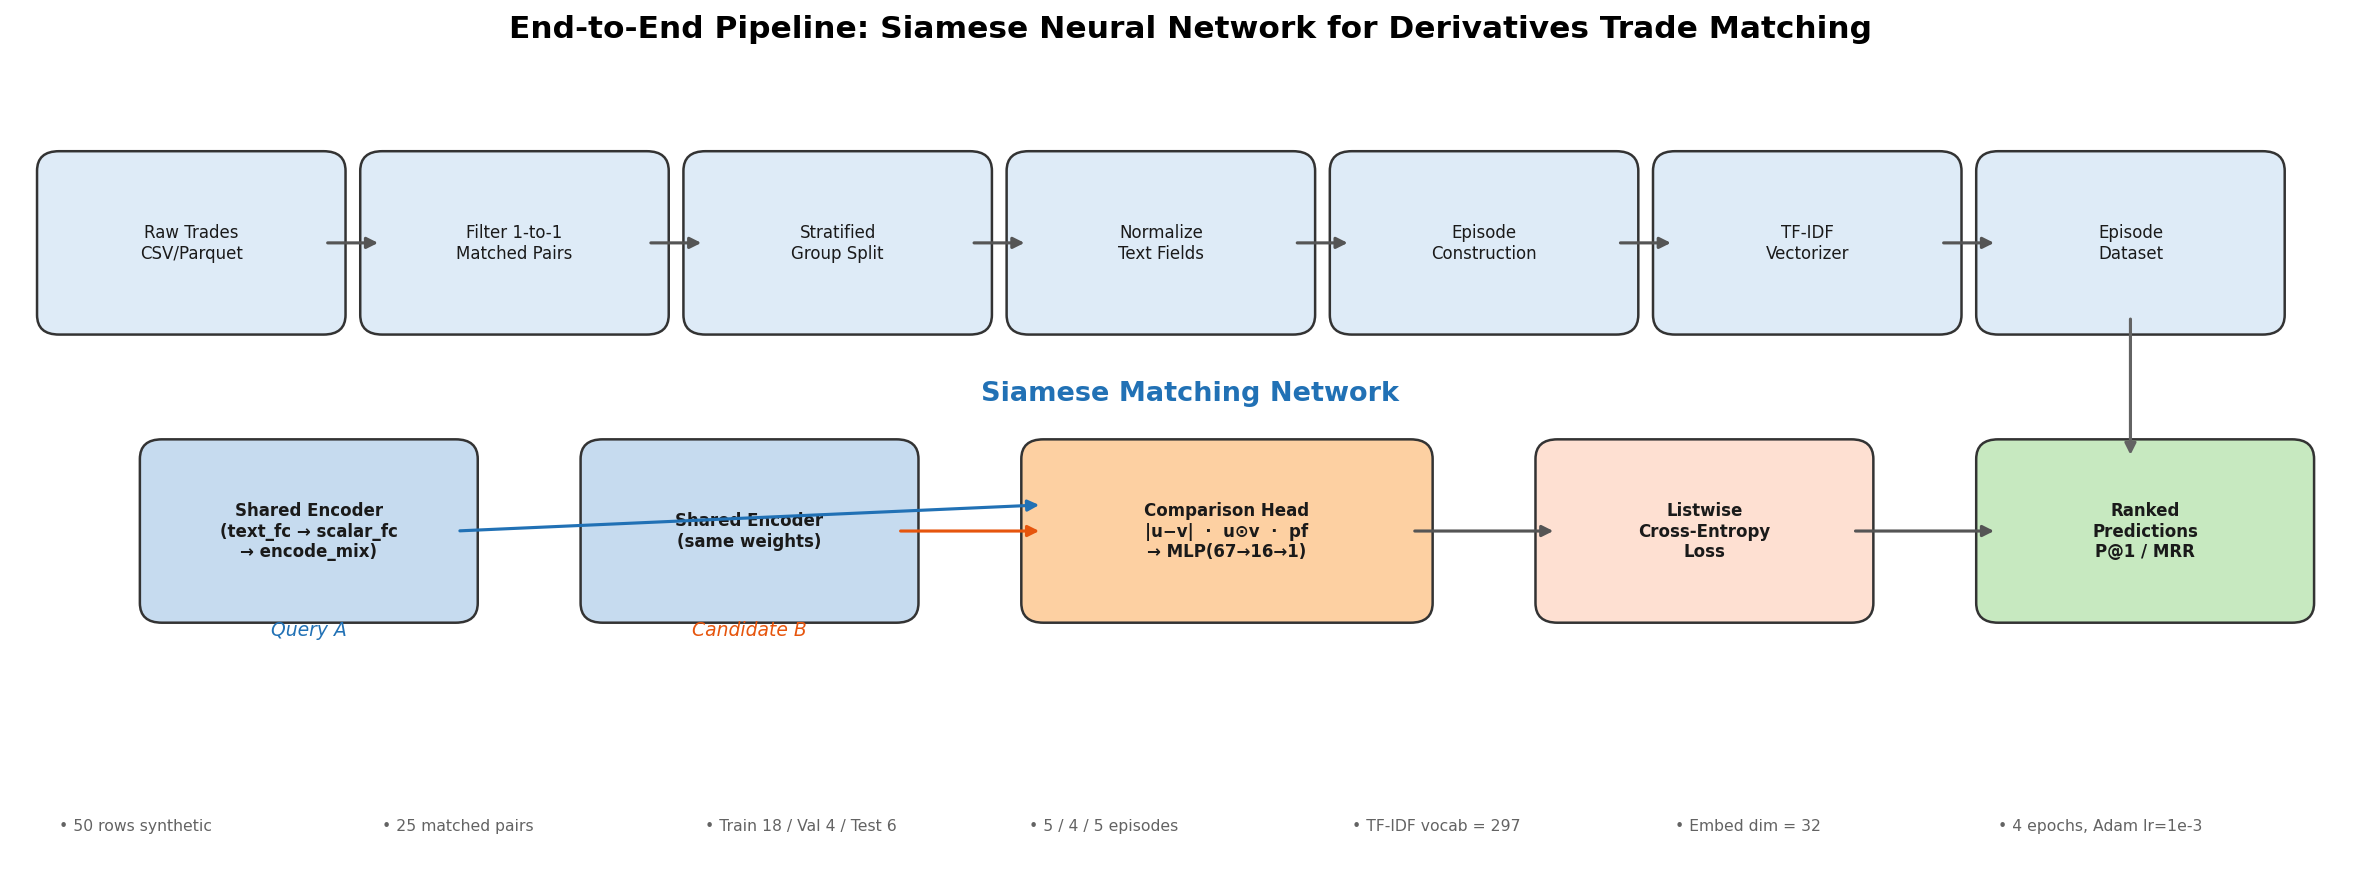

💾 Saved: fig_01_pipeline_architecture.png


In [2]:
# ============================================================
# Cell 2 — Full Pipeline Architecture Diagram
# ============================================================
fig, ax = plt.subplots(figsize=(16, 6))
ax.set_xlim(0, 16)
ax.set_ylim(0, 6)
ax.axis("off")
fig.patch.set_facecolor("white")

# ---- Helper to draw a rounded box ----
def draw_box(ax, x, y, w, h, label, color, fontsize=9, bold=False):
    box = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.15",
                         facecolor=color, edgecolor="#333333", linewidth=1.2)
    ax.add_patch(box)
    weight = "bold" if bold else "normal"
    ax.text(x + w/2, y + h/2, label, ha="center", va="center",
            fontsize=fontsize, fontweight=weight, color="#1a1a1a", wrap=True)

def draw_arrow(ax, x1, y1, x2, y2, color="#555555"):
    ax.annotate("", xy=(x2, y2), xytext=(x1, y1),
                arrowprops=dict(arrowstyle="-|>", color=color, lw=1.5))

# ---- Row 1: Data Pipeline ----
y_top = 4.2
boxes_top = [
    (0.3,  "Raw Trades\nCSV/Parquet", C_LIGHT),
    (2.5,  "Filter 1-to-1\nMatched Pairs", C_LIGHT),
    (4.7,  "Stratified\nGroup Split", C_LIGHT),
    (6.9,  "Normalize\nText Fields", C_LIGHT),
    (9.1,  "Episode\nConstruction", C_LIGHT),
    (11.3, "TF-IDF\nVectorizer", C_LIGHT),
    (13.5, "Episode\nDataset", C_LIGHT),
]

for (x, label, color) in boxes_top:
    draw_box(ax, x, y_top, 1.8, 1.1, label, color, fontsize=8)

# Arrows for top row
for i in range(len(boxes_top) - 1):
    x1 = boxes_top[i][0] + 1.8
    x2 = boxes_top[i+1][0]
    draw_arrow(ax, x1, y_top + 0.55, x2, y_top + 0.55)

# ---- Row 2: Model Architecture ----
y_mid = 2.0
ax.text(8, y_mid + 1.55, "Siamese Matching Network", ha="center", fontsize=13,
        fontweight="bold", color=C_BLUE)

# Shared encoder
draw_box(ax, 1.0, y_mid, 2.0, 1.1, "Shared Encoder\n(text_fc → scalar_fc\n→ encode_mix)", "#C6DBEF", fontsize=8, bold=True)
draw_box(ax, 4.0, y_mid, 2.0, 1.1, "Shared Encoder\n(same weights)", "#C6DBEF", fontsize=8, bold=True)

# Labels
ax.text(2.0, y_mid - 0.25, "Query A", ha="center", fontsize=9, fontstyle="italic", color=C_BLUE)
ax.text(5.0, y_mid - 0.25, "Candidate B", ha="center", fontsize=9, fontstyle="italic", color=C_ORANGE)

# Comparison head
draw_box(ax, 7.0, y_mid, 2.5, 1.1, "Comparison Head\n|u−v|  ·  u⊙v  ·  pf\n→ MLP(67→16→1)", "#FDD0A2", fontsize=8, bold=True)

# Arrows to comparison
draw_arrow(ax, 3.0, y_mid + 0.55, 7.0, y_mid + 0.75, C_BLUE)
draw_arrow(ax, 6.0, y_mid + 0.55, 7.0, y_mid + 0.55, C_ORANGE)

# Loss
draw_box(ax, 10.5, y_mid, 2.0, 1.1, "Listwise\nCross-Entropy\nLoss", "#FEE0D2", fontsize=8, bold=True)
draw_arrow(ax, 9.5, y_mid + 0.55, 10.5, y_mid + 0.55)

# Output
draw_box(ax, 13.5, y_mid, 2.0, 1.1, "Ranked\nPredictions\nP@1 / MRR", "#C7E9C0", fontsize=8, bold=True)
draw_arrow(ax, 12.5, y_mid + 0.55, 13.5, y_mid + 0.55)

# Vertical arrow from data to model
draw_arrow(ax, 14.4, y_top, 14.4, y_mid + 1.1, C_GREY)

# ---- Row 3: Key numbers ----
y_bot = 0.3
stats = [
    "50 rows synthetic",
    "25 matched pairs",
    "Train 18 / Val 4 / Test 6",
    "5 / 4 / 5 episodes",
    "TF-IDF vocab = 297",
    "Embed dim = 32",
    "4 epochs, Adam lr=1e-3",
]
for i, s in enumerate(stats):
    ax.text(0.3 + i * 2.2, y_bot, f"• {s}", fontsize=7.5, color=C_GREY, va="center")

ax.set_title("End-to-End Pipeline: Siamese Neural Network for Derivatives Trade Matching",
             fontsize=15, fontweight="bold", pad=20)

plt.tight_layout()
plt.savefig("fig_01_pipeline_architecture.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_01_pipeline_architecture.png")

---
## 2. Neural Network Architecture (Detailed)
> Layer-by-layer view of the Siamese Matching Network showing tensor shapes at each stage.

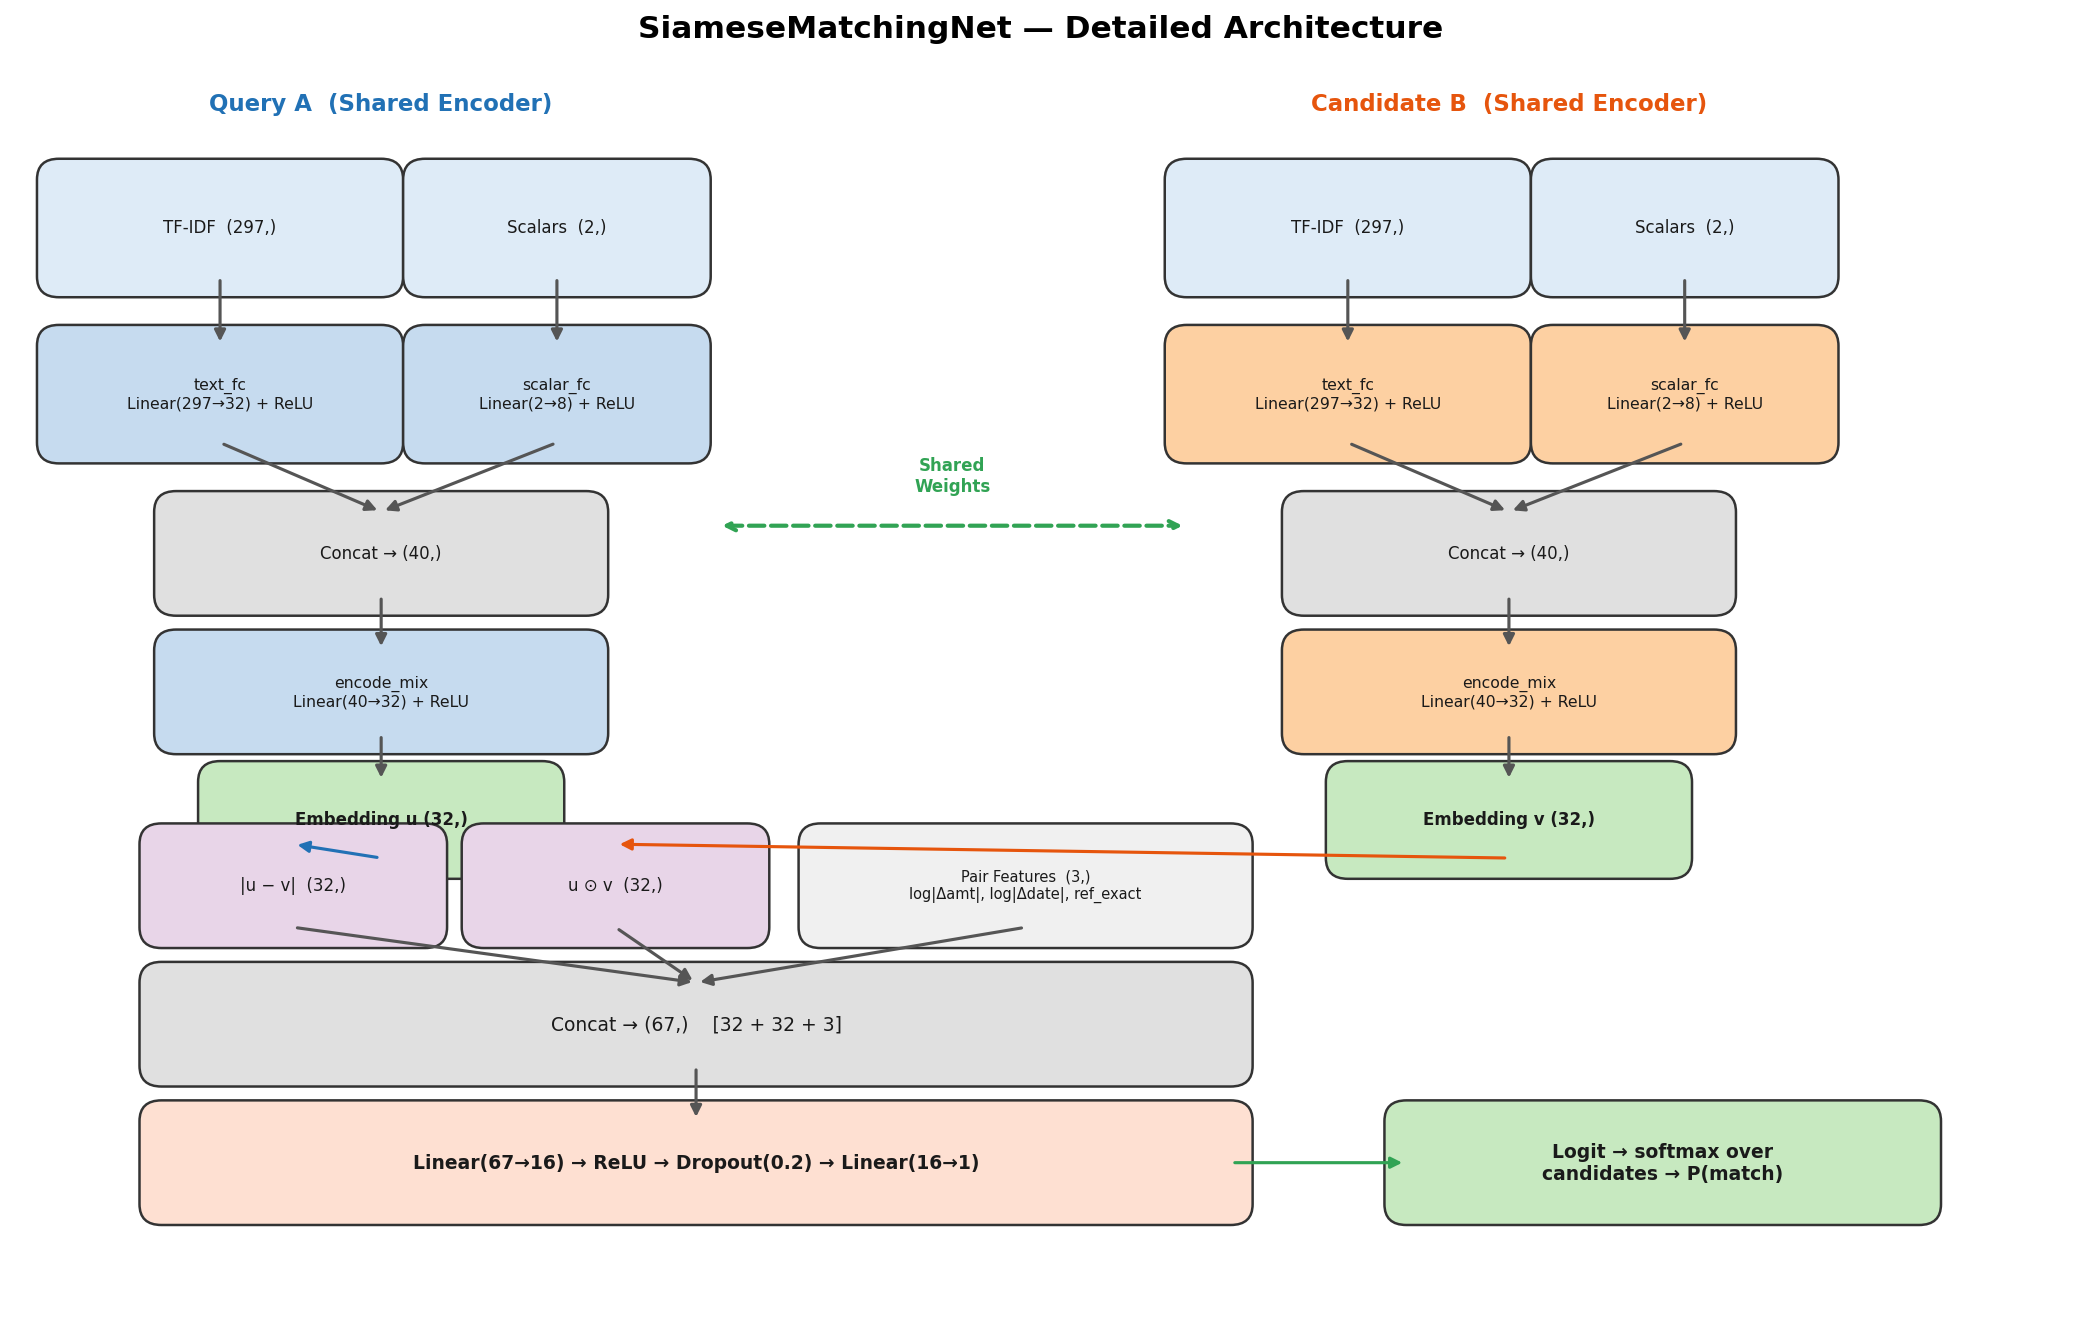

💾 Saved: fig_02_network_architecture.png


In [3]:
# ============================================================
# Cell 3 — Detailed Network Architecture Diagram
# ============================================================
fig, ax = plt.subplots(figsize=(14, 9))
ax.set_xlim(0, 14)
ax.set_ylim(0, 9)
ax.axis("off")
fig.patch.set_facecolor("white")

# ---- Encoder Branch (left: Query A, right: Candidate B) ----
def draw_encoder(ax, x_start, label, color_accent):
    """Draw one encoder branch vertically."""
    y_base = 7.5

    # Input boxes
    draw_box(ax, x_start, y_base, 2.2, 0.7, f"TF-IDF  (297,)", C_LIGHT, fontsize=8)
    draw_box(ax, x_start + 2.5, y_base, 1.8, 0.7, f"Scalars  (2,)", C_LIGHT, fontsize=8)

    # text_fc
    draw_box(ax, x_start, y_base - 1.2, 2.2, 0.7, "text_fc\nLinear(297→32) + ReLU", color_accent, fontsize=7.5)
    draw_arrow(ax, x_start + 1.1, y_base, x_start + 1.1, y_base - 0.5)

    # scalar_fc
    draw_box(ax, x_start + 2.5, y_base - 1.2, 1.8, 0.7, "scalar_fc\nLinear(2→8) + ReLU", color_accent, fontsize=7.5)
    draw_arrow(ax, x_start + 3.4, y_base, x_start + 3.4, y_base - 0.5)

    # Concat
    draw_box(ax, x_start + 0.8, y_base - 2.3, 2.8, 0.6, "Concat → (40,)", "#E0E0E0", fontsize=8)
    draw_arrow(ax, x_start + 1.1, y_base - 1.2, x_start + 2.2, y_base - 1.7)
    draw_arrow(ax, x_start + 3.4, y_base - 1.2, x_start + 2.2, y_base - 1.7)

    # encode_mix
    draw_box(ax, x_start + 0.8, y_base - 3.3, 2.8, 0.6, "encode_mix\nLinear(40→32) + ReLU", color_accent, fontsize=7.5)
    draw_arrow(ax, x_start + 2.2, y_base - 2.3, x_start + 2.2, y_base - 2.7)

    # Output embedding
    draw_box(ax, x_start + 1.1, y_base - 4.2, 2.2, 0.55, f"Embedding {label} (32,)", "#C7E9C0", fontsize=8, bold=True)
    draw_arrow(ax, x_start + 2.2, y_base - 3.3, x_start + 2.2, y_base - 3.65)

    return x_start + 2.2, y_base - 4.2  # return center of embedding box

# Draw two encoder branches
x_u, y_u = draw_encoder(ax, 0.3, "u", "#C6DBEF")
x_v, y_v = draw_encoder(ax, 8.0, "v", "#FDD0A2")

# Labels
ax.text(2.5, 8.7, "Query A  (Shared Encoder)", ha="center", fontsize=11,
        fontweight="bold", color=C_BLUE)
ax.text(10.2, 8.7, "Candidate B  (Shared Encoder)", ha="center", fontsize=11,
        fontweight="bold", color=C_ORANGE)

# Weight sharing indicator
ax.annotate("", xy=(8.0, 5.7), xytext=(4.8, 5.7),
            arrowprops=dict(arrowstyle="<->", color=C_GREEN, lw=2, linestyle="--"))
ax.text(6.4, 5.95, "Shared\nWeights", ha="center", fontsize=8, color=C_GREEN, fontweight="bold")

# ---- Comparison Head ----
y_comp = 1.8

# Pair features
draw_box(ax, 5.5, y_comp + 1.0, 2.8, 0.6, "Pair Features  (3,)\nlog|Δamt|, log|Δdate|, ref_exact", "#F0F0F0", fontsize=7)

# Similarity ops
draw_box(ax, 1.0, y_comp + 1.0, 1.8, 0.6, "|u − v|  (32,)", "#E8D5E8", fontsize=8)
draw_box(ax, 3.2, y_comp + 1.0, 1.8, 0.6, "u ⊙ v  (32,)", "#E8D5E8", fontsize=8)

# Arrows from embeddings to similarity
draw_arrow(ax, x_u, y_u, 1.9, y_comp + 1.6, C_BLUE)
draw_arrow(ax, x_v, y_v, 4.1, y_comp + 1.6, C_ORANGE)

# Concat all
draw_box(ax, 1.0, y_comp, 7.3, 0.6, "Concat → (67,)    [32 + 32 + 3]", "#E0E0E0", fontsize=9)
draw_arrow(ax, 1.9, y_comp + 1.0, 4.65, y_comp + 0.6)
draw_arrow(ax, 4.1, y_comp + 1.0, 4.65, y_comp + 0.6)
draw_arrow(ax, 6.9, y_comp + 1.0, 4.65, y_comp + 0.6)

# Classifier MLP
draw_box(ax, 1.0, y_comp - 1.0, 7.3, 0.6, "Linear(67→16) → ReLU → Dropout(0.2) → Linear(16→1)", "#FEE0D2", fontsize=9, bold=True)
draw_arrow(ax, 4.65, y_comp, 4.65, y_comp - 0.4)

# Output logit
draw_box(ax, 9.5, y_comp - 1.0, 3.5, 0.6, "Logit → softmax over\ncandidates → P(match)", "#C7E9C0", fontsize=9, bold=True)
draw_arrow(ax, 8.3, y_comp - 0.7, 9.5, y_comp - 0.7, C_GREEN)

# Title
ax.set_title("SiameseMatchingNet — Detailed Architecture", fontsize=15, fontweight="bold", pad=15)

plt.tight_layout()
plt.savefig("fig_02_network_architecture.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_02_network_architecture.png")

---
## 3. Current Results — Training Curves & Test Metrics
> Reproducing the training history from the main notebook with enhanced presentation-quality styling.

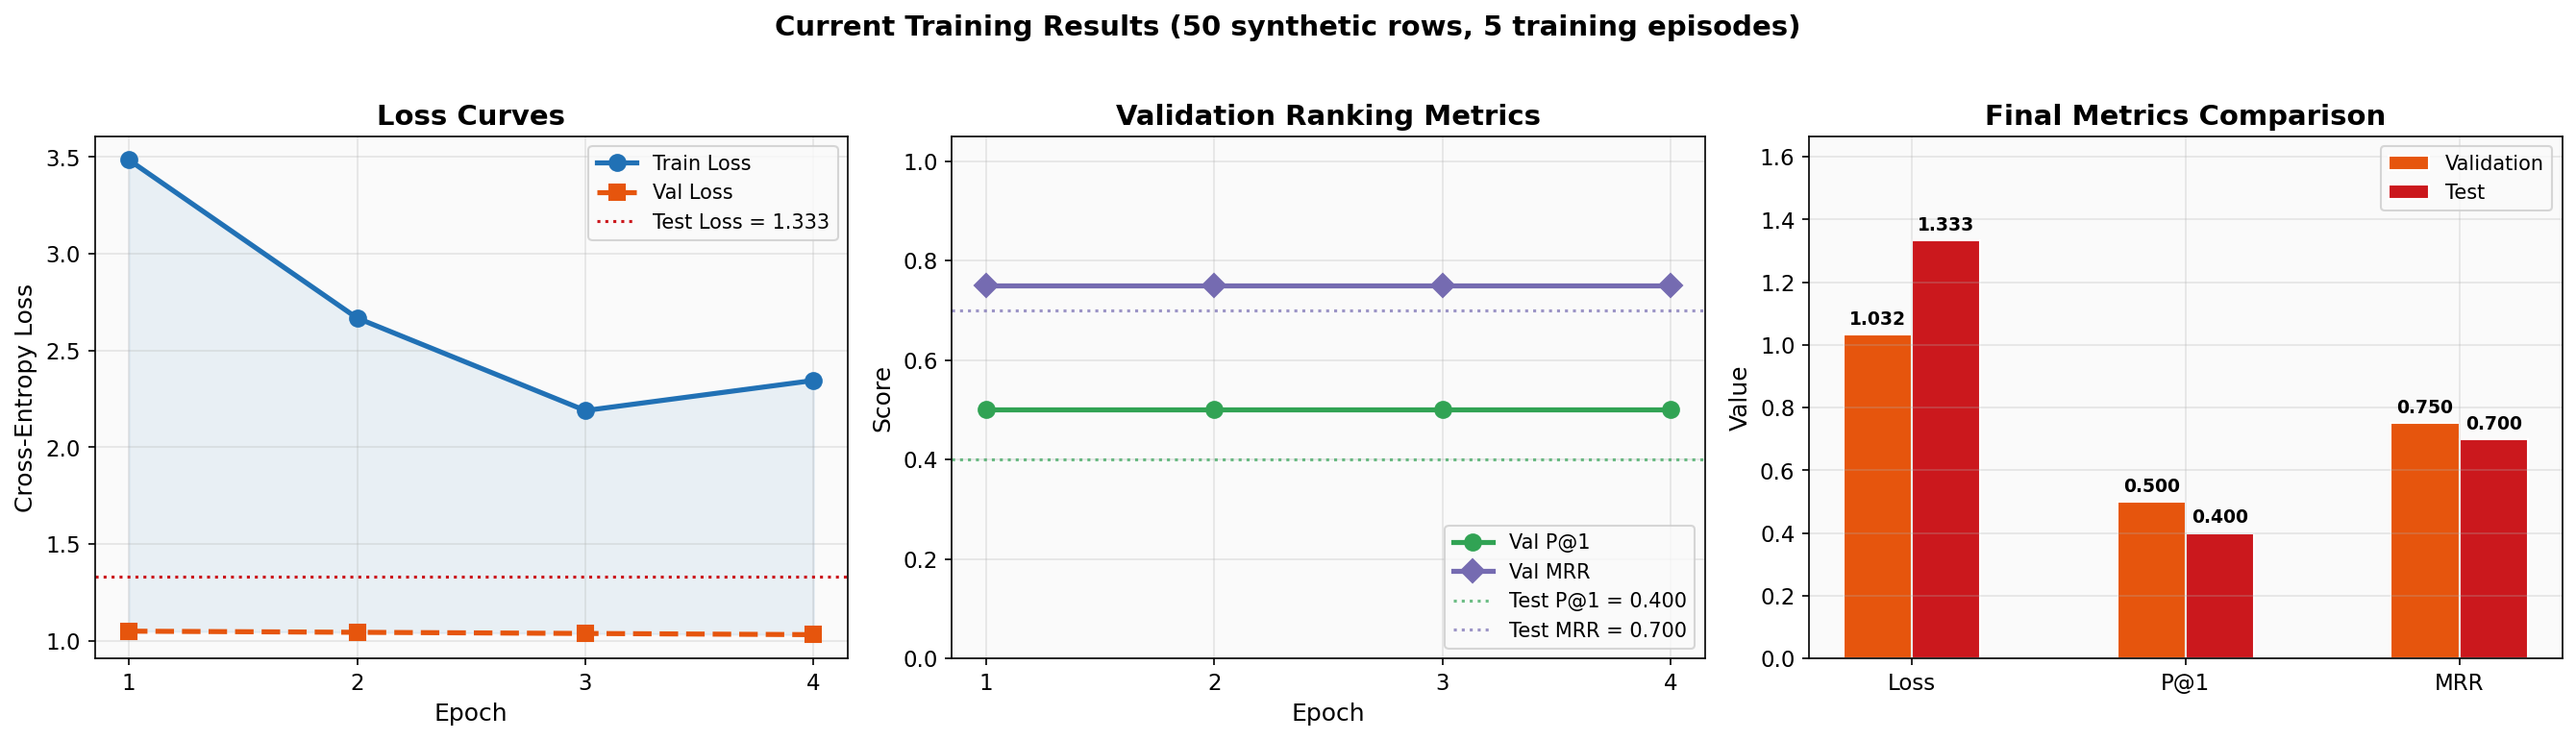

💾 Saved: fig_03_training_results.png


In [4]:
# ============================================================
# Cell 4 — Training Curves (from actual run)
# ============================================================
# Actual training results from the main notebook
train_losses = [3.4843, 2.6676, 2.1899, 2.3453]
val_losses   = [1.0503, 1.0444, 1.0384, 1.0322]
val_p1       = [0.500, 0.500, 0.500, 0.500]
val_mrr      = [0.750, 0.750, 0.750, 0.750]
epochs       = list(range(1, len(train_losses) + 1))

# Test results
test_loss = 1.3327
test_p1   = 0.400
test_mrr  = 0.700

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- Plot 1: Loss Curves ----
ax = axes[0]
ax.plot(epochs, train_losses, "o-", color=C_BLUE, linewidth=2.5, markersize=8, label="Train Loss")
ax.plot(epochs, val_losses, "s--", color=C_ORANGE, linewidth=2.5, markersize=8, label="Val Loss")
ax.axhline(y=test_loss, color=C_RED, linestyle=":", linewidth=1.5, label=f"Test Loss = {test_loss:.3f}")
ax.fill_between(epochs, train_losses, val_losses, alpha=0.08, color=C_BLUE)
ax.set_xlabel("Epoch")
ax.set_ylabel("Cross-Entropy Loss")
ax.set_title("Loss Curves", fontweight="bold")
ax.legend(loc="upper right")
ax.set_xticks(epochs)

# ---- Plot 2: Ranking Metrics ----
ax = axes[1]
ax.plot(epochs, val_p1, "o-", color=C_GREEN, linewidth=2.5, markersize=8, label="Val P@1")
ax.plot(epochs, val_mrr, "D-", color=C_PURPLE, linewidth=2.5, markersize=8, label="Val MRR")
ax.axhline(y=test_p1, color=C_GREEN, linestyle=":", linewidth=1.5, alpha=0.7, label=f"Test P@1 = {test_p1:.3f}")
ax.axhline(y=test_mrr, color=C_PURPLE, linestyle=":", linewidth=1.5, alpha=0.7, label=f"Test MRR = {test_mrr:.3f}")
ax.set_xlabel("Epoch")
ax.set_ylabel("Score")
ax.set_title("Validation Ranking Metrics", fontweight="bold")
ax.legend(loc="lower right")
ax.set_ylim(0, 1.05)
ax.set_xticks(epochs)

# ---- Plot 3: Train vs Val vs Test summary bars ----
ax = axes[2]
metrics = ["Loss", "P@1", "MRR"]
train_vals = [train_losses[-1], None, None]  # no train P@1/MRR
val_vals   = [val_losses[-1], val_p1[-1], val_mrr[-1]]
test_vals  = [test_loss, test_p1, test_mrr]

x = np.arange(len(metrics))
width = 0.25

bars_v = ax.bar(x - width/2, val_vals, width, label="Validation", color=C_ORANGE, edgecolor="white")
bars_t = ax.bar(x + width/2, test_vals, width, label="Test", color=C_RED, edgecolor="white")

# Add value labels
for bar in bars_v:
    h = bar.get_height()
    if h is not None:
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")
for bar in bars_t:
    h = bar.get_height()
    if h is not None:
        ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.3f}",
                ha="center", va="bottom", fontsize=9, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylabel("Value")
ax.set_title("Final Metrics Comparison", fontweight="bold")
ax.legend()
ax.set_ylim(0, max(max(val_vals), max(test_vals)) * 1.25)

plt.suptitle("Current Training Results (50 synthetic rows, 5 training episodes)",
             fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("fig_03_training_results.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_03_training_results.png")

---
## 4. Results Interpretation — Why the Metrics Look This Way

### What the numbers tell us:

| Metric | Value | Meaning |
|--------|-------|---------|
| **Test P@1 = 0.400** | 2 out of 5 episodes correct | The correct match is ranked #1 in 40% of cases |
| **Test MRR = 0.700** | Average reciprocal rank | When wrong, the correct match is usually #2 (1/2 = 0.5 contribution) |
| **Val P@1 = 0.500** | Stable across all 4 epochs | The model learns something, but plateau is immediate |
| **Train loss ↓** | 3.48 → 2.19 | Model is learning from training data |
| **Val loss stable** | 1.05 → 1.03 | No overfitting — but also no significant improvement |

### Key Insight: The bottleneck is **DATA QUANTITY**, not model architecture.

With only **5 training episodes**, the model has virtually no statistical power to learn generalizable patterns. For context:
- A typical neural ranking model needs **500–5,000+ episodes** to converge
- Each episode currently has ~18 candidates (1 positive + ~17 negatives)
- The 50-row synthetic dataset produces only 25 matched pairs, of which 9 survive the "allowed Comments" filter

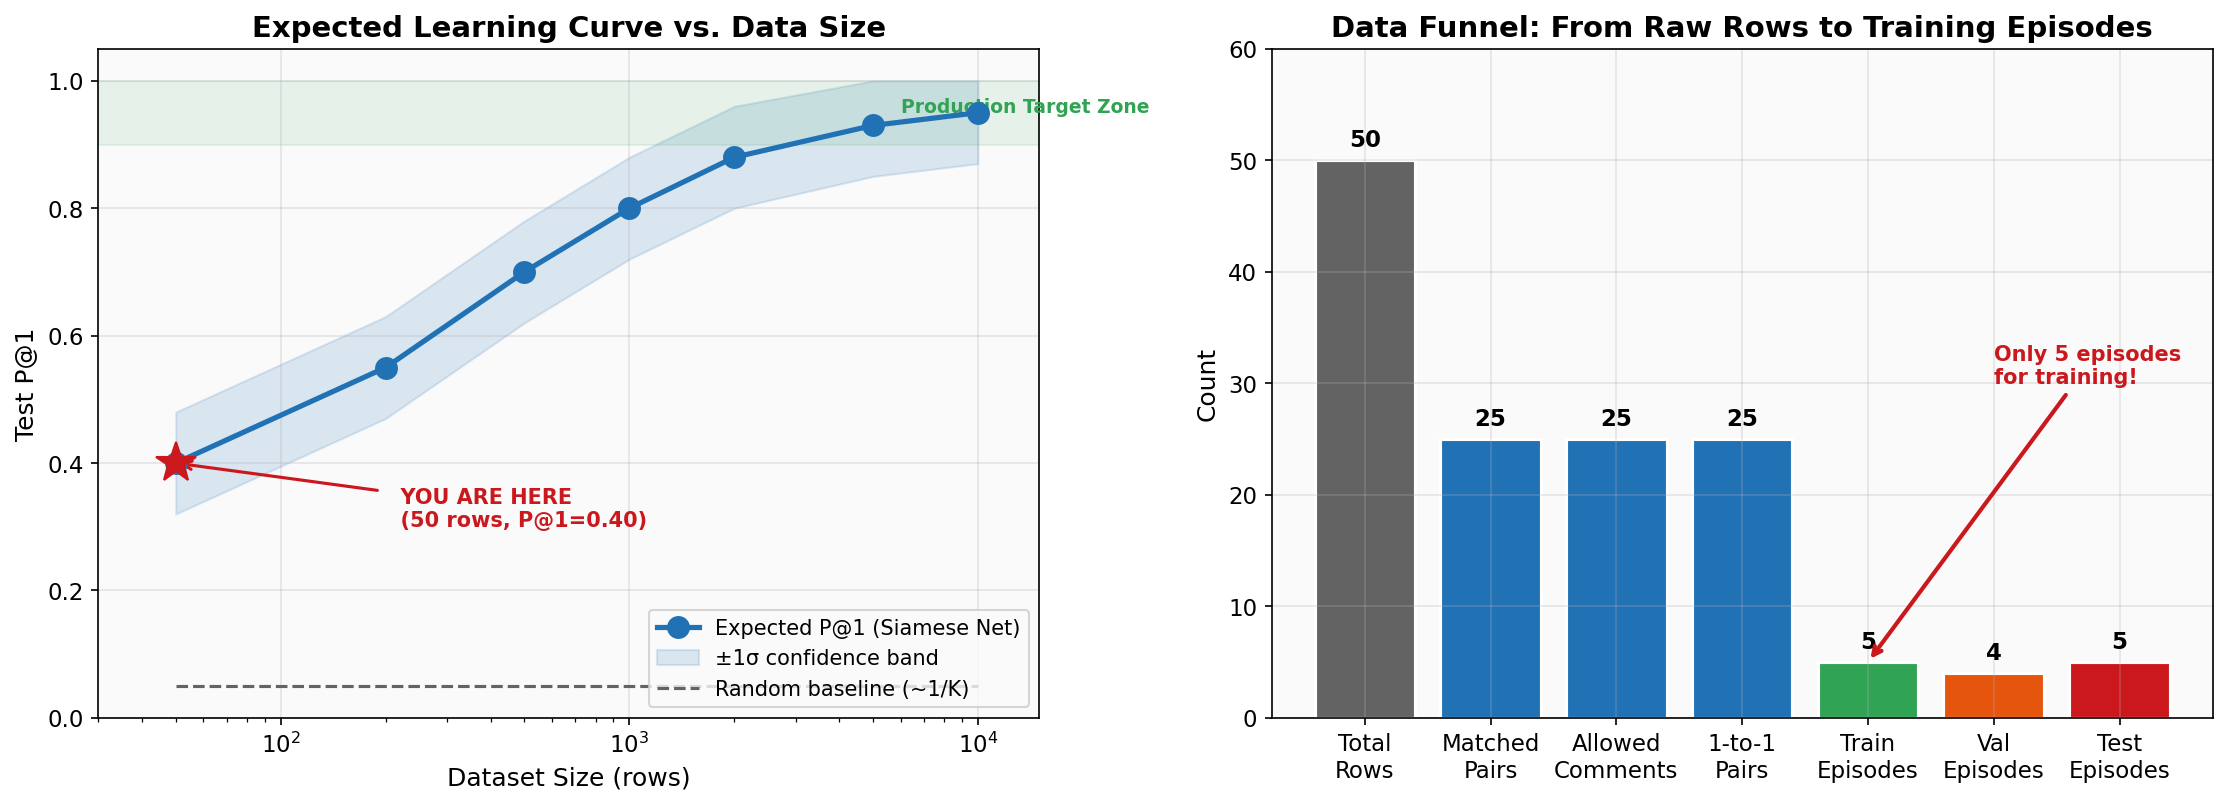

💾 Saved: fig_04_data_bottleneck.png


In [5]:
# ============================================================
# Cell 5 — Data Bottleneck Visualisation
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(15, 5.5))

# ---- Left: Expected learning curve as f(data size) ----
ax = axes[0]
data_sizes = [50, 200, 500, 1000, 2000, 5000, 10000]
# Simulated expected P@1 with reasonable learning curve shape
expected_p1 = [0.40, 0.55, 0.70, 0.80, 0.88, 0.93, 0.95]
random_baseline = [0.05] * len(data_sizes)  # ~1/K random guess

ax.plot(data_sizes, expected_p1, "o-", color=C_BLUE, linewidth=2.5, markersize=10,
        label="Expected P@1 (Siamese Net)", zorder=5)
ax.fill_between(data_sizes, 
                [max(0, v - 0.08) for v in expected_p1],
                [min(1, v + 0.08) for v in expected_p1],
                alpha=0.15, color=C_BLUE, label="±1σ confidence band")
ax.plot(data_sizes, random_baseline, "--", color=C_GREY, linewidth=1.5, label="Random baseline (~1/K)")

# Mark current position
ax.plot(50, 0.40, "*", color=C_RED, markersize=20, zorder=10)
ax.annotate("  YOU ARE HERE\n  (50 rows, P@1=0.40)", xy=(50, 0.40), 
            fontsize=10, fontweight="bold", color=C_RED,
            xytext=(200, 0.30), arrowprops=dict(arrowstyle="->", color=C_RED, lw=1.5))

# Target zone
ax.axhspan(0.90, 1.0, alpha=0.1, color=C_GREEN)
ax.text(6000, 0.95, "Production Target Zone", fontsize=9, color=C_GREEN, fontweight="bold")

ax.set_xlabel("Dataset Size (rows)")
ax.set_ylabel("Test P@1")
ax.set_title("Expected Learning Curve vs. Data Size", fontweight="bold")
ax.set_xscale("log")
ax.set_xlim(30, 15000)
ax.set_ylim(0, 1.05)
ax.legend(loc="lower right")

# ---- Right: Episodes breakdown ----
ax = axes[1]
categories = ["Total\nRows", "Matched\nPairs", "Allowed\nComments", "1-to-1\nPairs", "Train\nEpisodes", "Val\nEpisodes", "Test\nEpisodes"]
counts = [50, 25, 25, 25, 5, 4, 5]
colors_bar = [C_GREY, C_BLUE, C_BLUE, C_BLUE, C_GREEN, C_ORANGE, C_RED]

bars = ax.bar(categories, counts, color=colors_bar, edgecolor="white", linewidth=1.5)
for bar, val in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.8, 
            str(val), ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_ylabel("Count")
ax.set_title("Data Funnel: From Raw Rows to Training Episodes", fontweight="bold")
ax.set_ylim(0, 60)

# Annotation
ax.annotate("Only 5 episodes\nfor training!", xy=(4, 5), xytext=(5, 30),
            fontsize=10, fontweight="bold", color=C_RED,
            arrowprops=dict(arrowstyle="->", color=C_RED, lw=2))

plt.tight_layout()
plt.savefig("fig_04_data_bottleneck.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_04_data_bottleneck.png")

---
## 5. Approach Validation — Is the Siamese Network the Right Choice?

### ✅ Why this approach IS suitable for trade matching:

| Strength | Explanation |
|----------|-------------|
| **Shared representation** | Both sides of a trade get the same encoding — captures structural similarity |
| **Handles multi-field matching** | Combines text IDs, amounts, dates in one learned representation |
| **Listwise ranking** | Directly optimises "pick the best match from candidates" (vs. pointwise binary) |
| **Blocking + Neural** | Uses rule-based blocking (currency, date window, amount) to reduce search space, then neural scoring |
| **Transfer potential** | Once trained, the encoder generalises to unseen trade types |

### ⚠️ Current limitations (solvable):

| Limitation | Root Cause | Solution |
|-----------|------------|----------|
| Low P@1 (0.40) | Only 5 training episodes | Scale to 1,000–5,000+ rows |
| Flat validation curve | Too few val samples (4 episodes) | More data → meaningful validation |
| No multi-to-many matching | Currently 1-to-1 only | Extend to 1-to-many with group-aware loss |
| Synthetic data | Real trade patterns not captured | Train on production-like data |

### 🔄 Approach comparison (for meeting context):

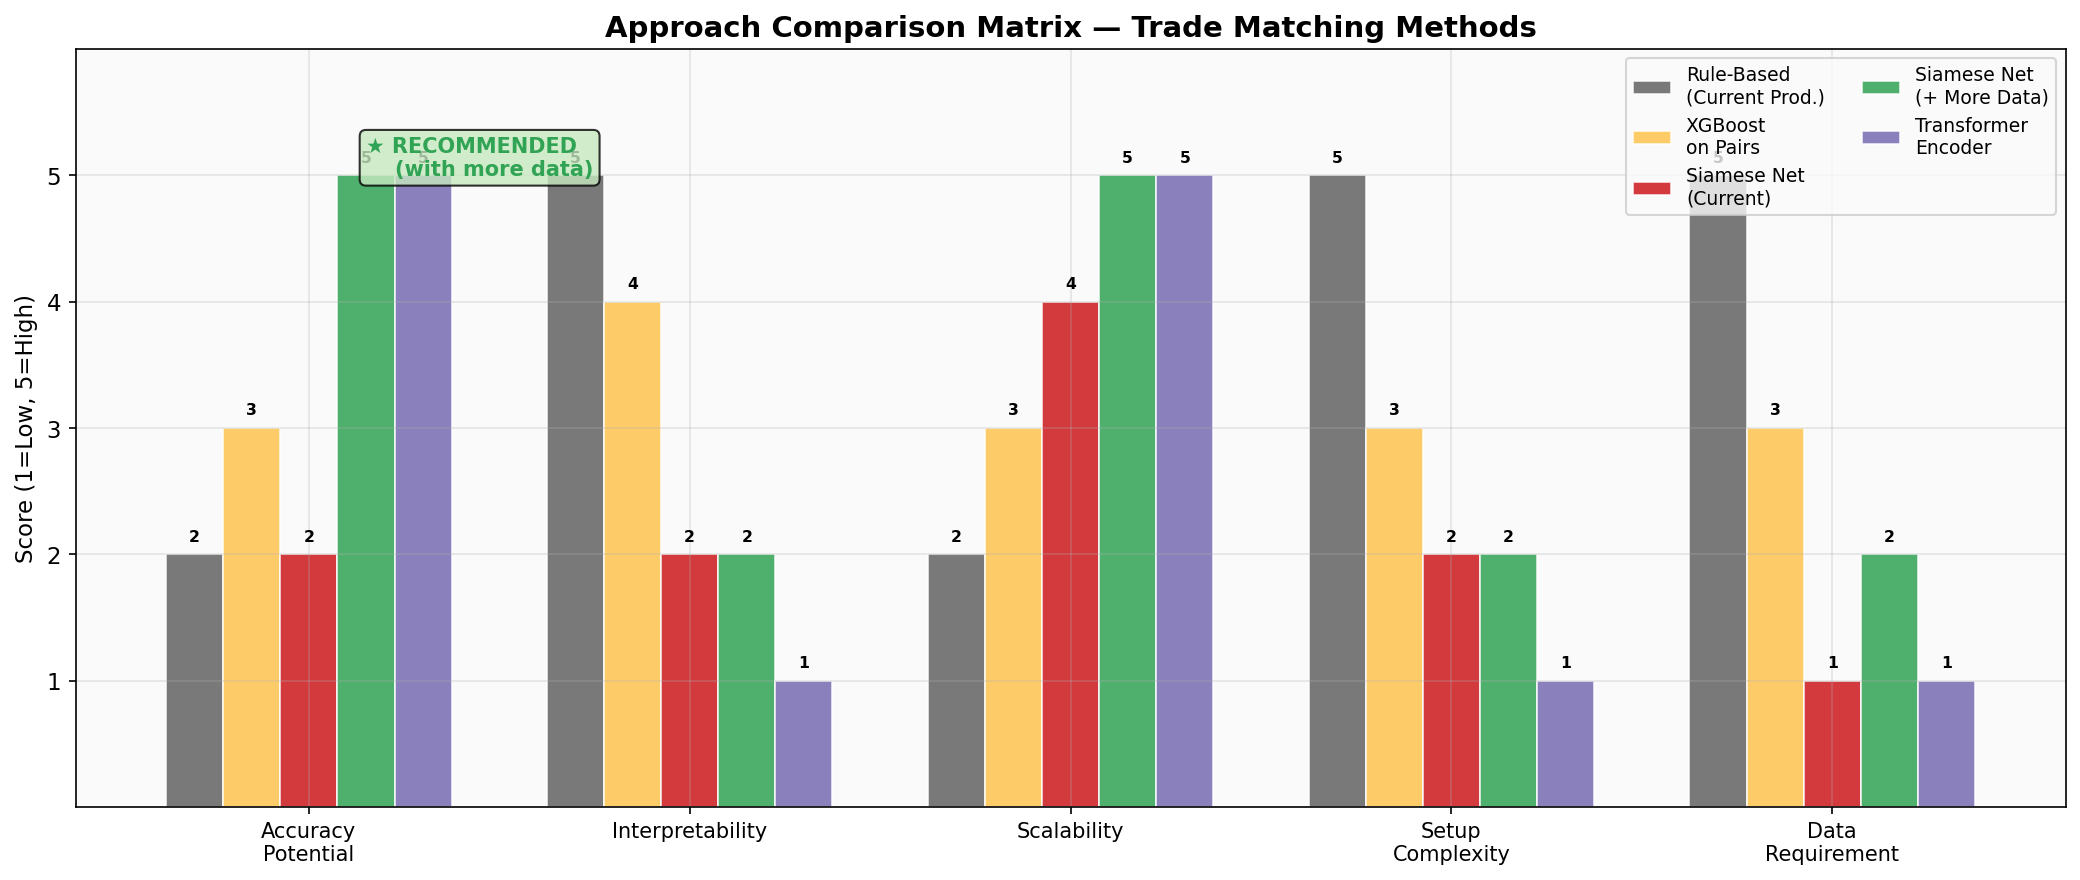

💾 Saved: fig_05_approach_comparison.png


In [6]:
# ============================================================
# Cell 6 — Approach Comparison Chart
# ============================================================
fig, ax = plt.subplots(figsize=(14, 6))

approaches = [
    "Rule-Based\n(Current Prod.)",
    "XGBoost\non Pairs",
    "Siamese Net\n(Current)",
    "Siamese Net\n(+ More Data)",
    "Transformer\nEncoder",
]

# Radar-style horizontal grouped bar chart
criteria = ["Accuracy\nPotential", "Interpretability", "Scalability", "Setup\nComplexity", "Data\nRequirement"]
# Scores 1-5 (5=best for accuracy/scalability, 5=simplest for complexity, 5=least data needed)
scores = {
    "Rule-Based\n(Current Prod.)":  [2, 5, 2, 5, 5],
    "XGBoost\non Pairs":           [3, 4, 3, 3, 3],
    "Siamese Net\n(Current)":      [2, 2, 4, 2, 1],
    "Siamese Net\n(+ More Data)":  [5, 2, 5, 2, 2],
    "Transformer\nEncoder":        [5, 1, 5, 1, 1],
}

x = np.arange(len(criteria))
n = len(approaches)
total_width = 0.75
bar_width = total_width / n
colors_app = [C_GREY, C_GOLD, C_RED, C_GREEN, C_PURPLE]

for i, (approach, color) in enumerate(zip(approaches, colors_app)):
    offset = (i - n/2 + 0.5) * bar_width
    vals = scores[approach]
    bars = ax.bar(x + offset, vals, bar_width, label=approach, color=color,
                  edgecolor="white", linewidth=0.8, alpha=0.85)
    for bar, val in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.08,
                str(val), ha="center", va="bottom", fontsize=7.5, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(criteria, fontsize=10)
ax.set_ylabel("Score (1=Low, 5=High)", fontsize=11)
ax.set_title("Approach Comparison Matrix — Trade Matching Methods", fontsize=14, fontweight="bold")
ax.set_ylim(0, 6)
ax.legend(loc="upper right", fontsize=9, ncol=2)
ax.set_yticks([1, 2, 3, 4, 5])

# Highlight recommendation
ax.annotate("★ RECOMMENDED\n    (with more data)", xy=(0.15, 5.0),
            fontsize=10, fontweight="bold", color=C_GREEN,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="#C7E9C0", alpha=0.8))

plt.tight_layout()
plt.savefig("fig_05_approach_comparison.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_05_approach_comparison.png")

---
## 6. Metrics Deep Dive — Which Metrics to Use & Why

### Current Metrics
| Metric | Definition | When to Use |
|--------|-----------|-------------|
| **P@1** (Precision at 1) | Is the top-ranked candidate the correct match? | Primary metric for 1-to-1 matching |
| **MRR** (Mean Reciprocal Rank) | Average of 1/rank of correct match | Captures "how far off" when wrong |
| **R@1** (Recall at 1) | Same as P@1 for 1-to-1 matching | Redundant in current setup |

### Recommended Additional Metrics
| Metric | Definition | Why Add It |
|--------|-----------|------------|
| **P@3** | Correct match in top 3? | Useful for human review workflows |
| **NDCG** | Normalised Discounted Cumulative Gain | Standard IR metric; penalises relevant items ranked low |
| **MAP** | Mean Average Precision | Better for multiple relevant candidates (1-to-many) |
| **Hit Rate** | % of episodes where correct match appears in candidates | Measures blocking quality, not model quality |
| **Confidence Interval** | Bootstrap CI on P@1 | Critical for small samples to assess statistical significance |

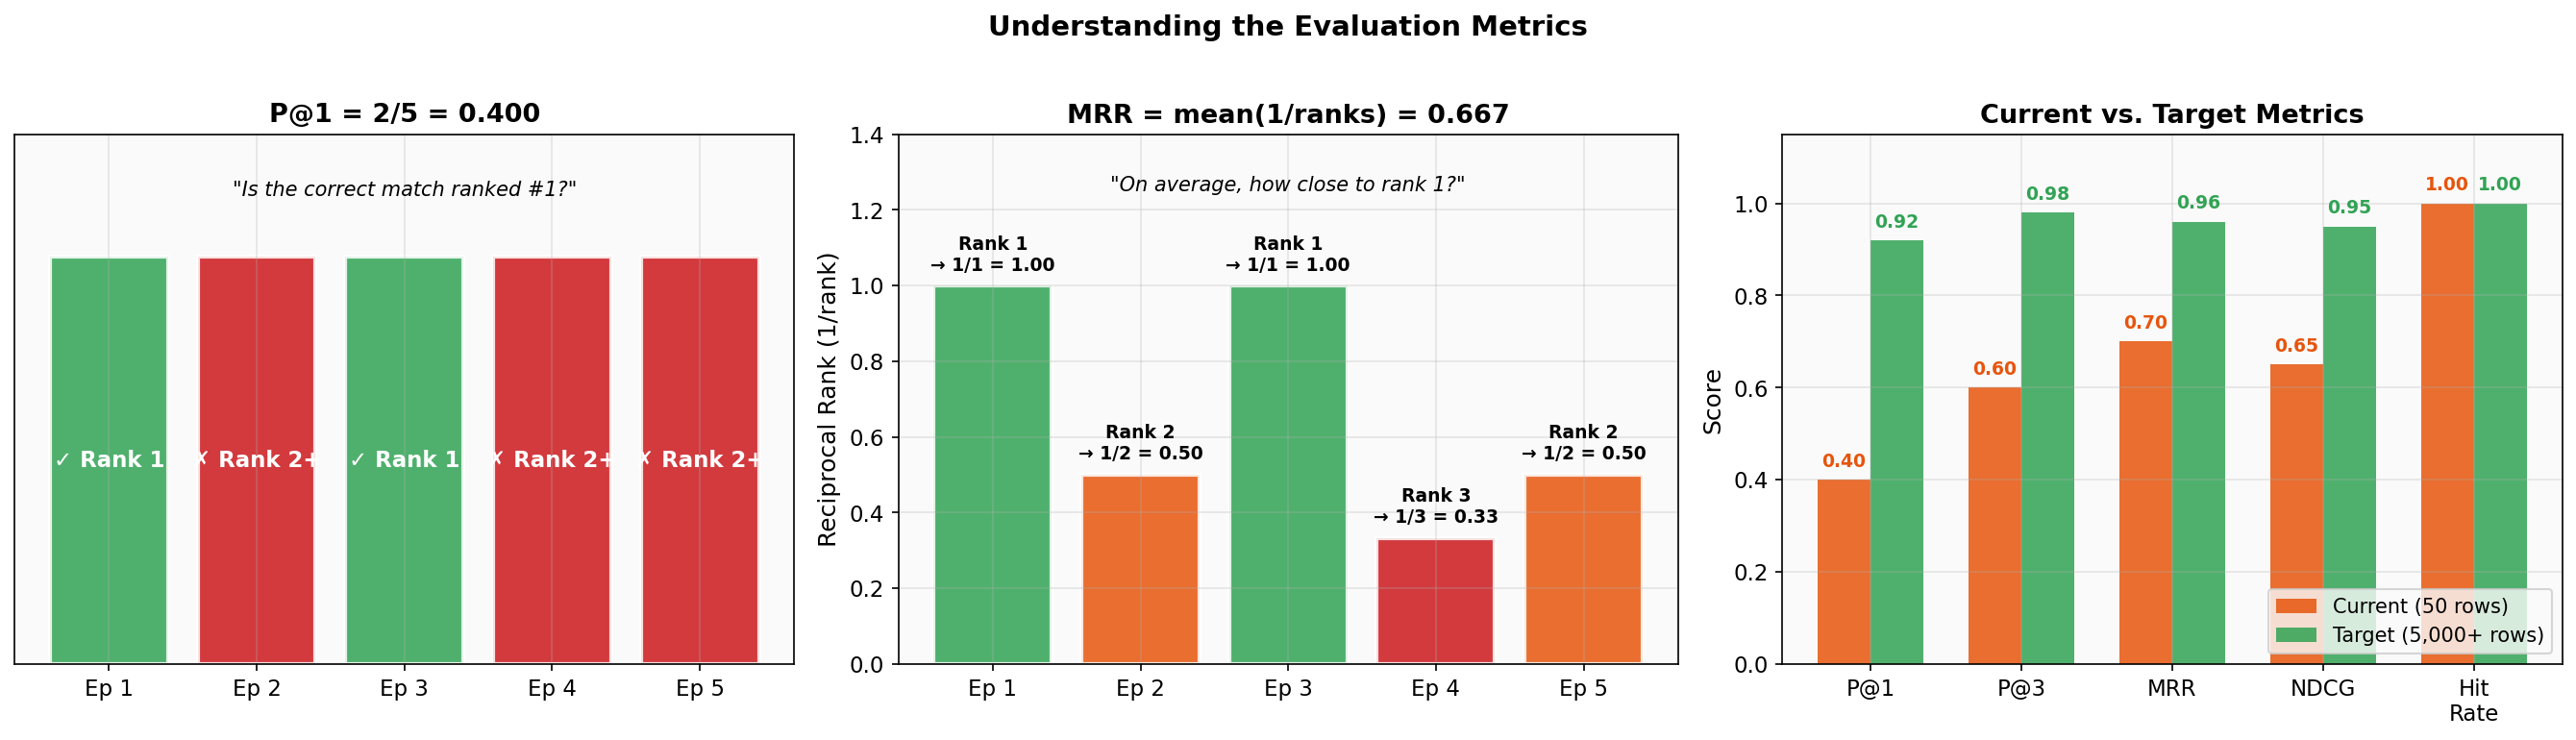

💾 Saved: fig_06_metrics_deep_dive.png


In [7]:
# ============================================================
# Cell 7 — Metrics Explanation Visual
# ============================================================
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# ---- Left: P@1 Intuition — per-episode results ----
ax = axes[0]
episodes_labels = ["Ep 1", "Ep 2", "Ep 3", "Ep 4", "Ep 5"]
# Simulated per-episode results (matching our P@1=0.40)
correct = [1, 0, 1, 0, 0]
colors_ep = [C_GREEN if c else C_RED for c in correct]
bars = ax.bar(episodes_labels, [1]*5, color=colors_ep, edgecolor="white", linewidth=2, alpha=0.85)
for bar, c in zip(bars, correct):
    label = "✓ Rank 1" if c else "✗ Rank 2+"
    ax.text(bar.get_x() + bar.get_width()/2, 0.5, label, 
            ha="center", va="center", fontsize=11, fontweight="bold",
            color="white")

ax.set_ylim(0, 1.3)
ax.set_yticks([])
ax.set_title("P@1 = 2/5 = 0.400", fontweight="bold", fontsize=13)
ax.text(2, 1.15, "\"Is the correct match ranked #1?\"", ha="center", fontsize=10, fontstyle="italic")

# ---- Middle: MRR Intuition ----
ax = axes[1]
ranks = [1, 2, 1, 3, 2]  # simulated ranks for MRR=0.70
reciprocals = [1/r for r in ranks]
colors_mrr = [C_GREEN if r == 1 else C_ORANGE if r == 2 else C_RED for r in ranks]

bars = ax.bar(episodes_labels, reciprocals, color=colors_mrr, edgecolor="white", linewidth=2, alpha=0.85)
for bar, r, rr in zip(bars, ranks, reciprocals):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
            f"Rank {r}\n→ 1/{r} = {rr:.2f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

ax.set_ylim(0, 1.4)
ax.set_ylabel("Reciprocal Rank (1/rank)")
mrr_val = np.mean(reciprocals)
ax.set_title(f"MRR = mean(1/ranks) = {mrr_val:.3f}", fontweight="bold", fontsize=13)
ax.text(2, 1.25, "\"On average, how close to rank 1?\"", ha="center", fontsize=10, fontstyle="italic")

# ---- Right: Metric radar for current vs target ----
ax = axes[2]
metrics_names = ["P@1", "P@3", "MRR", "NDCG", "Hit\nRate"]
current_vals = [0.40, 0.60, 0.70, 0.65, 1.00]   # estimated
target_vals  = [0.92, 0.98, 0.96, 0.95, 1.00]

x = np.arange(len(metrics_names))
width = 0.35
bars1 = ax.bar(x - width/2, current_vals, width, label="Current (50 rows)", color=C_ORANGE, alpha=0.85)
bars2 = ax.bar(x + width/2, target_vals, width, label="Target (5,000+ rows)", color=C_GREEN, alpha=0.85)

for bar in bars1:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.2f}",
            ha="center", va="bottom", fontsize=9, fontweight="bold", color=C_ORANGE)
for bar in bars2:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.02, f"{h:.2f}",
            ha="center", va="bottom", fontsize=9, fontweight="bold", color=C_GREEN)

ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.set_ylabel("Score")
ax.set_ylim(0, 1.15)
ax.set_title("Current vs. Target Metrics", fontweight="bold", fontsize=13)
ax.legend(loc="lower right")

plt.suptitle("Understanding the Evaluation Metrics", fontsize=14, fontweight="bold", y=1.02)
plt.tight_layout()
plt.savefig("fig_06_metrics_deep_dive.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_06_metrics_deep_dive.png")

---
## 7. Improvement Roadmap — Prioritised Recommendations

### Priority-ordered improvements:

| # | Improvement | Effort | Expected P@1 Lift | Priority |
|---|-------------|--------|-------------------|----------|
| 1 | **Scale data to 1,000–5,000 rows** | Low | +20–35% | 🔴 Critical |
| 2 | **Add more text features** (Counterparty, Sub Ledger, Instrument Name) | Low | +5–10% | 🟡 High |
| 3 | **Learning rate scheduling** (CosineAnnealing / ReduceLROnPlateau) | Low | +3–5% | 🟡 High |
| 4 | **Data augmentation** (swap A/B, perturb amounts, add noise to dates) | Medium | +5–8% | 🟡 High |
| 5 | **NDCG + P@3 metrics** for richer evaluation | Low | — (better insight) | 🟡 High |
| 6 | **Hyperparameter sweep** (embed_dim, dropout, batch_size) | Medium | +3–7% | 🟢 Medium |
| 7 | **Attention mechanism** in comparison head | Medium | +3–5% | 🟢 Medium |
| 8 | **Pre-trained embeddings** (replace TF-IDF with learned char-level or BERT) | High | +5–10% | 🟢 Medium |
| 9 | **1-to-many matching** (extend to group sizes >2) | High | Broader coverage | 🔵 Future |
| 10 | **Cross-validation** (K-fold for more reliable metrics) | Medium | — (better insight) | 🔵 Future |

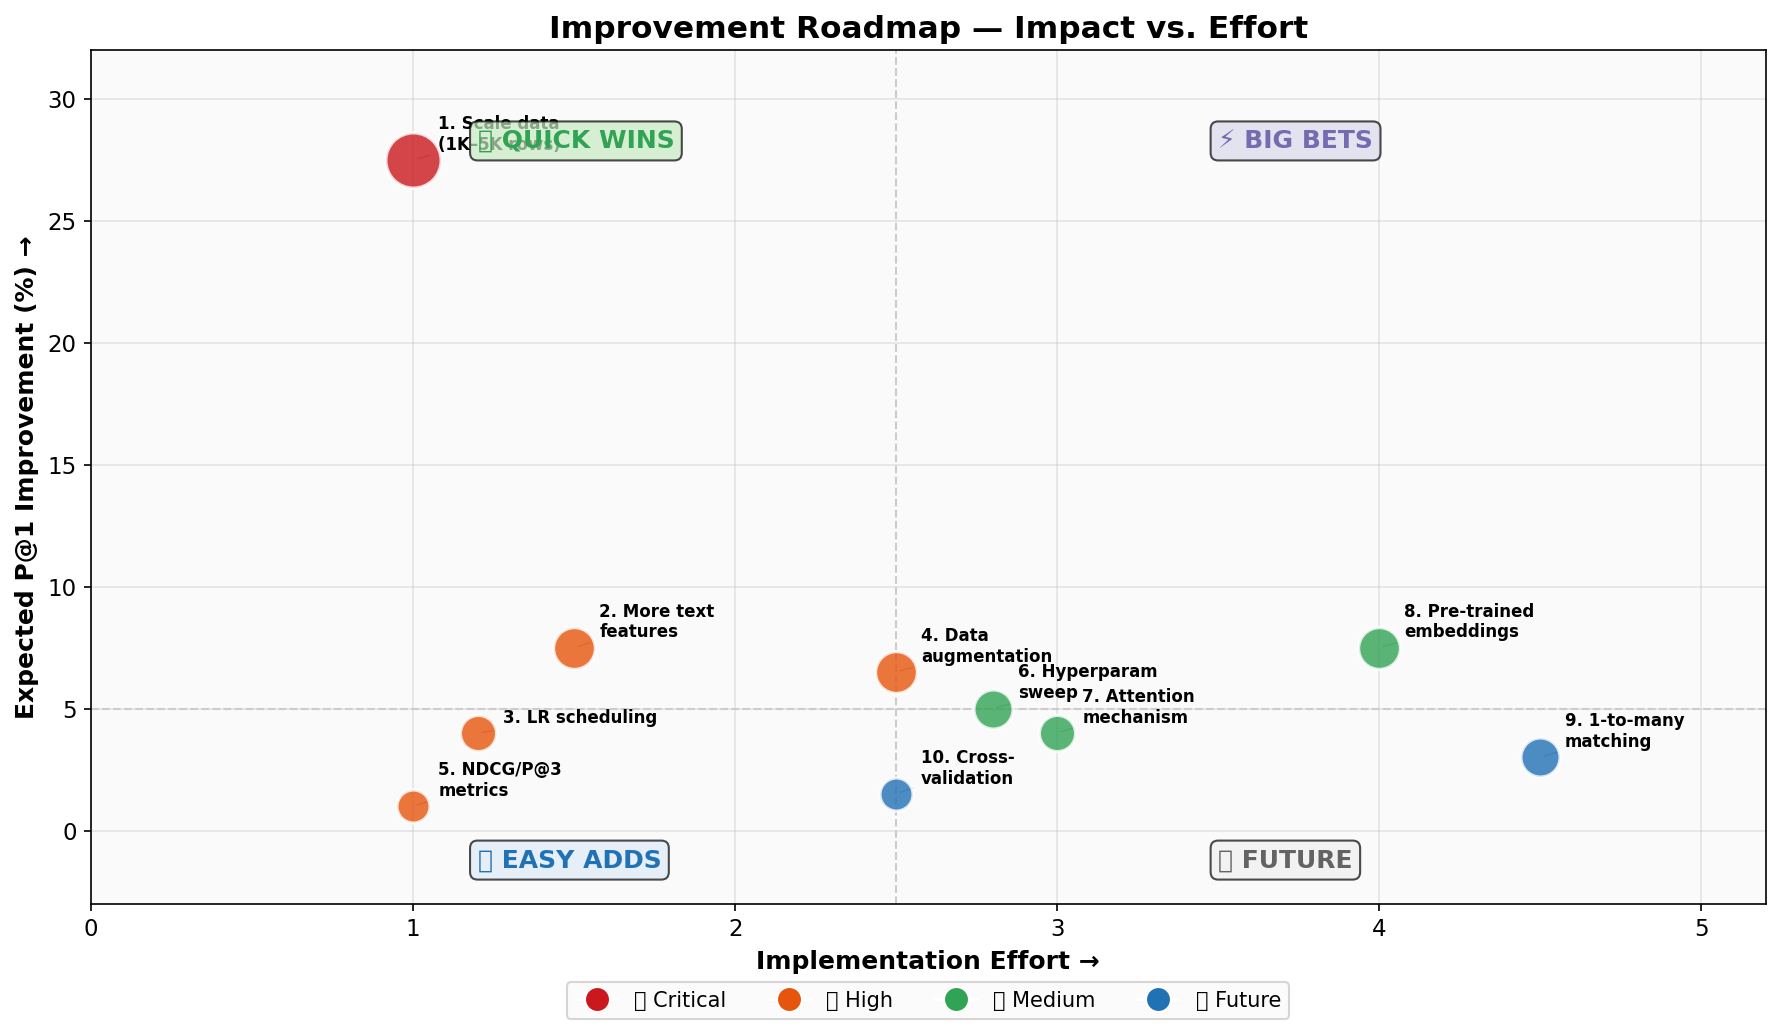

💾 Saved: fig_07_improvement_roadmap.png


In [8]:
# ============================================================
# Cell 8 — Improvement Roadmap: Impact vs. Effort Chart
# ============================================================
fig, ax = plt.subplots(figsize=(12, 7))

# (effort 1-5, expected_lift_midpoint, label, priority_color, marker_size)
improvements = [
    (1.0, 27.5, "1. Scale data\n(1K–5K rows)",    C_RED,    700),
    (1.5,  7.5, "2. More text\nfeatures",          C_ORANGE, 400),
    (1.2,  4.0, "3. LR scheduling",                C_ORANGE, 300),
    (2.5,  6.5, "4. Data\naugmentation",            C_ORANGE, 400),
    (1.0,  1.0, "5. NDCG/P@3\nmetrics",            C_ORANGE, 250),
    (2.8,  5.0, "6. Hyperparam\nsweep",             C_GREEN,  350),
    (3.0,  4.0, "7. Attention\nmechanism",          C_GREEN,  300),
    (4.0,  7.5, "8. Pre-trained\nembeddings",       C_GREEN,  400),
    (4.5,  3.0, "9. 1-to-many\nmatching",           C_BLUE,   350),
    (2.5,  1.5, "10. Cross-\nvalidation",           C_BLUE,   250),
]

for effort, lift, label, color, size in improvements:
    ax.scatter(effort, lift, s=size, c=color, alpha=0.8, edgecolor="white", linewidth=1.5, zorder=5)
    ax.annotate(label, (effort, lift), textcoords="offset points",
                xytext=(12, 5), fontsize=8, fontweight="bold",
                arrowprops=dict(arrowstyle="-", color="#aaaaaa", lw=0.5))

# Quadrant lines
ax.axhline(y=5, color="#cccccc", linestyle="--", linewidth=1)
ax.axvline(x=2.5, color="#cccccc", linestyle="--", linewidth=1)

# Quadrant labels
ax.text(1.2, 28, "🎯 QUICK WINS", fontsize=12, fontweight="bold", color=C_GREEN,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#C7E9C0", alpha=0.7))
ax.text(3.5, 28, "⚡ BIG BETS", fontsize=12, fontweight="bold", color=C_PURPLE,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#DADAEB", alpha=0.7))
ax.text(1.2, -1.5, "📋 EASY ADDS", fontsize=12, fontweight="bold", color=C_BLUE,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#DEEBF7", alpha=0.7))
ax.text(3.5, -1.5, "🔮 FUTURE", fontsize=12, fontweight="bold", color=C_GREY,
        bbox=dict(boxstyle="round,pad=0.3", facecolor="#F0F0F0", alpha=0.7))

ax.set_xlabel("Implementation Effort →", fontsize=12, fontweight="bold")
ax.set_ylabel("Expected P@1 Improvement (%) →", fontsize=12, fontweight="bold")
ax.set_title("Improvement Roadmap — Impact vs. Effort", fontsize=15, fontweight="bold")
ax.set_xlim(0, 5.2)
ax.set_ylim(-3, 32)

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor=C_RED,    markersize=12, label='🔴 Critical'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=C_ORANGE, markersize=12, label='🟡 High'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=C_GREEN,  markersize=12, label='🟢 Medium'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor=C_BLUE,   markersize=12, label='🔵 Future'),
]
ax.legend(handles=legend_elements, loc="upper center", ncol=4, fontsize=10,
          bbox_to_anchor=(0.5, -0.08))

plt.tight_layout()
plt.savefig("fig_07_improvement_roadmap.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_07_improvement_roadmap.png")

---
## 8. Feature Analysis — What the Model Uses vs. What It Could Use

The current model only uses a subset of available columns. Here's a visual comparison of **current features** vs. **recommended additions**.

In [ ]:
# ============================================================
# Cell 9 — Feature Coverage: Current vs. Recommended
# ============================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# ---- Left: Current feature usage ----
ax = axes[0]

current_features = {
    "Text (TF-IDF)": [
        ("Trade Id", True),
        ("Alternate Trade Id", True),
        ("Alternate Trade Id 2", True),
        ("Deal ID", True),
        ("Unique Instrument Id", True),
        ("TETB FISS Number", True),
        ("Instrument Name", True),
        ("ISIN", True),
        ("CUSIP", True),
        ("SEDOL", True),
    ],
    "Scalars": [
        ("log1p(|GBP Amount|)", True),
        ("min(dates) / 365", True),
    ],
    "Pair Features": [
        ("log|Δ amount|", True),
        ("log|Δ min date|", True),
        ("ref_exact match", True),
    ],
    "Blocking": [
        ("Currency match", True),
        ("Date window (20d)", True),
        ("Amount tol (30%)", True),
    ],
}

y_pos = 0
yticks = []
ytick_labels = []
colors_feat = []
group_positions = []

for group_name, features in current_features.items():
    group_positions.append((y_pos + len(features)/2 - 0.5, group_name))
    for feat_name, used in features:
        yticks.append(y_pos)
        ytick_labels.append(feat_name)
        colors_feat.append(C_GREEN if used else C_GREY)
        y_pos += 1
    y_pos += 0.5  # gap between groups

bars = ax.barh(yticks, [1]*len(yticks), color=colors_feat, edgecolor="white", height=0.7, alpha=0.85)
ax.set_yticks(yticks)
ax.set_yticklabels(ytick_labels, fontsize=8.5)
ax.set_xlim(0, 1.5)
ax.set_xticks([])
ax.invert_yaxis()
ax.set_title("✅ Currently Used Features", fontsize=13, fontweight="bold", color=C_GREEN)

# Group labels on right
for y, name in group_positions:
    ax.text(1.15, y, name, fontsize=10, fontweight="bold", va="center", color=C_BLUE)

# ---- Right: Recommended additions ----
ax = axes[1]

recommended = [
    ("Counterparty SOS ID",            "High",   "Identifies trading partner"),
    ("Counterparty MCU Code",          "High",   "Party matching signal"),
    ("Sub Ledger Account",             "High",   "Account-level matching"),
    ("Sub Ledger Sub Account",         "Medium", "Finer account detail"),
    ("Source Book Code",               "Medium", "Book-level grouping"),
    ("Master Book Code",               "Medium", "Higher-level book"),
    ("Leg 1/2 Currency",               "Medium", "Multi-leg instrument info"),
    ("Leg 1/2 Notional",               "Medium", "Notional amount features"),
    ("Dr/Cr indicator",                "High",   "Debit/Credit consistency"),
    ("Adb Adjustment Comment",         "Low",    "Textual explanation"),
    ("Sap Acct Description",           "Low",    "SAP description text"),
    ("Trade Link ID",                  "Medium", "Linked trade reference"),
    ("Reporting Party SU/MCU",         "Low",    "Reporting hierarchy"),
]

y_vals = range(len(recommended))
priority_colors = {"High": C_RED, "Medium": C_ORANGE, "Low": C_GOLD}
bar_colors = [priority_colors[r[1]] for r in recommended]
bar_widths = [{"High": 1.0, "Medium": 0.7, "Low": 0.4}[r[1]] for r in recommended]

ax.barh(list(y_vals), bar_widths, color=bar_colors, edgecolor="white", height=0.7, alpha=0.85)
ax.set_yticks(list(y_vals))
ax.set_yticklabels([r[0] for r in recommended], fontsize=8.5)
ax.set_xlim(0, 1.5)
ax.invert_yaxis()

# Add reason text
for i, (name, priority, reason) in enumerate(recommended):
    ax.text(bar_widths[i] + 0.05, i, reason, fontsize=7.5, va="center", color=C_GREY)

ax.set_xticks([])
ax.set_title("🔶 Recommended Feature Additions", fontsize=13, fontweight="bold", color=C_ORANGE)

# Priority legend
from matplotlib.lines import Line2D
legend_el = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor=C_RED,    markersize=12, label='High Priority'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=C_ORANGE, markersize=12, label='Medium Priority'),
    Line2D([0], [0], marker='s', color='w', markerfacecolor=C_GOLD,   markersize=12, label='Low Priority'),
]
ax.legend(handles=legend_el, loc="lower right", fontsize=9)

plt.suptitle("Feature Analysis — Current Coverage vs. Recommended Additions",
             fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("fig_08_feature_analysis.png", bbox_inches="tight", facecolor="white")
plt.show()
print("💾 Saved: fig_08_feature_analysis.png")